In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.utils import shuffle
from tqdm import tqdm
from typing import Tuple, List, Type, Dict, Any

In [ ]:
from queue import Empty, Queue
from threading import Thread
import threading
#Threads libraries

In [2]:
# data augmentation library
from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa 


In [ ]:
#mount Drive for data transfer
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/geo_kaggle/index.pkl', 'rb') as f:
    data_index = pickle.load(f)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU', f'({torch.cuda.get_device_name(), torch.cuda.get_device_properties(device)})')
else:
    device = torch.device('cpu')
    print('Using CPU')


Using GPU (('Tesla T4', _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)))


In [ ]:
class thread_killer(object):    
    """Boolean object for signaling a worker thread to terminate
    Once a thread is launched, it should be terminated at some moment.
    In case the function of this thread is an infinite loop, one needs a mutex
    for signaling a worker thread to break the loop.
    The fuction will return, and the thread will be terminated.
    """
    
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [ ]:
def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
    """
    Threaded worker for pre-processing input data.
    tokill (thread_killer): an object that indicates whether a thread should be terminated
    dataset_generator (Dataset): training/validation data generator
    batches_queue (Queue): a limited size thread-safe Queue instance for train/validation data batches
    """
    while tokill() == False:
        for sample_batch in dataset_generator:
            
            batches_queue.put(sample_batch, block=True)
            
            if tokill() == True:
                return

In [ ]:
def threaded_cuda_batches(tokill, cuda_batches_queue, batches_queue):
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue (Queue): the queue that fetches numpy cpu tensors.
    cuda_batches_queue (Queue): the queue receiving numpy cpu tensors and transfering them to GPU memory.
    """
    while tokill() == False:
        sample_batch,labels,ids = batches_queue.get(block=True)
        sample_batch = Variable(sample_batch).to(device)
        labels = labels.to(device)
        ids = ids.to(device)
        
        cuda_batches_queue.put((sample_batch,labels,ids), block=True)
        if tokill() == True:
            return

In [ ]:
class Threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def get_objects_id(objects_count):
    """Cyclic generator of paths indices"""
    current_objects_id = 0
    while True:
        yield current_objects_id
        current_objects_id  = (current_objects_id + 1) % objects_count

In [ ]:
class SkyDataset(Dataset):    
    def __init__(self, 
                 data_frame, 
                 root_dir, 
                 transform=None, 
                 batch_size = 8, 
                 augment = True,
                 seq = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 5))],random_order=True), 
                 train = True, 
                 target = True):
        """
        Args:
            pkl_file (string): Path to the pkl file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            batch_size (int, optional): batch size
        """
        self.is_train = train
        self.with_target = target
        self.sky_data = data_frame
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        
        self.batch_size = batch_size
        
        self.objects_id_generator = Threadsafe_iter(get_objects_id(self.sky_data.shape[0]))
        
        self.lock = threading.Lock()
        self.yield_lock = threading.Lock()
        self.init_count = 0
        self.augment = augment
        self.cache = {}
        
        if self.augment:
            # instantiate augmentations
            self.seq = seq
        
    def __len__(self):                        
        return self.sky_data.shape[0]
    

    def shuffle(self):
        self.sky_data = shuffle(self.sky_data).reset_index(drop=True)
    
    def __iter__(self):
        while True:
            with self.lock:
                if (self.init_count == 0):
                    if self.is_train:
                        self.shuffle()
                    self.imgs = []
                    self.labels = []
                    self.ids =[]
                    self.init_count = 1
            
            
            for obj_id in self.objects_id_generator:
                add_str =''
                if(self.with_target and self.sky_data.iloc[obj_id]['mission'] == 'AI49'):
                    add_str = 'ai49-'
                
                
                
                img_name = os.path.join(self.root_dir, self.sky_data.iloc[obj_id]['mission'], 'snapshots', add_str + 'snapshots-'+str((self.sky_data.iloc[obj_id]['observations_dt']).date()), self.sky_data.iloc[obj_id]['jpg_filename'])
                mask_name = os.path.join(self.root_dir, self.sky_data.iloc[obj_id]['mission'], 'masks', 'mask-id'+str(self.sky_data.iloc[obj_id]['devID'])+'.png') 
                if (self.with_target):
                  label = int(self.sky_data.iloc[obj_id]['observed_TCC'])      
                
                  
               
               #Mask for photos, very expensive operation
               # mask = plt.imread(mask_name)
               # mask = np.where(mask == 255, np.ones_like(mask),mask*0)
                       
                
                
                img = plt.imread(img_name)
                img = torchvision.transforms.Compose([
                                                      torchvision.transforms.ToPILImage(), 
                                                    torchvision.transforms.Resize([256, 256]),
                                                    torchvision.transforms.ToTensor()
                                                    ])(img)
                if self.transform:
                    img = self.transform(img)
                img= img.numpy()
                                                 
                if self.augment:
                    img = self.seq(images = img)
                                                
                    # Concurrent access by multiple threads to the lists below
                with self.yield_lock:
                    if (len(self.imgs)) < self.batch_size:
                        self.imgs.append(img)
                        if self.with_target:
                            self.labels.append(label)
                        if self.with_target == False :
                            self.ids.append(obj_id)
                    if (obj_id + 1 == len(self)):
                        yield (torch.Tensor(np.array(self.imgs)),(torch.Tensor(self.labels)).type(torch.LongTensor), torch.Tensor(self.ids))
                        self.imgs = []
                        self.labels = []
                        self.jpg_names =[]
                        break    
                    if len(self.imgs) % self.batch_size == 0:
                     
                        yield (torch.Tensor(np.array(self.imgs)),(torch.Tensor(self.labels)).type(torch.LongTensor), torch.Tensor(self.ids))
                        self.imgs = []
                        self.labels = []
                        self.ids =[]

                    
            # At the end of an epoch we re-init data-structures
            with self.lock:
                if self.is_train:
                    self.sky_data = shuffle(self.sky_data)
                self.init_count = 0

In [ ]:
#funtion for training single epoch which is full data set divided to batches and transfered to GPU via multiple threads
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       STEPS_PER_EPOCH,
                       train_cuda_batches_queue,
                       data_len):
    
    model.train()
    loss_sum = 0

    for image_batch in tqdm(range(STEPS_PER_EPOCH), total=STEPS_PER_EPOCH):
      
        x,y, ids = train_cuda_batches_queue.get(block = True)
        
        model.zero_grad()
        hyp = model(x)
       
      
        loss = loss_function(hyp, y)
        loss.backward()
        loss_sum += loss
        
        optimizer.step()

    
    return loss_sum/float(data_len)

In [ ]:
@torch.no_grad()
# Validating of test data with accuracy metric, also transfered to GPU via multiple threads
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,                          
                          STEPS_PER_EPOCH,
                          test_cuda_batches_queue,
                          data_len):
    model.eval()
    loss_sum = 0
    accuracy = 0
    
    for image_batch in range(STEPS_PER_EPOCH):
        
        x,y,ids = test_cuda_batches_queue.get(block = True)

        hyp = model(x)
        loss = loss_function(hyp, y)
        loss_sum += loss

        y_pred = hyp.argmax(dim = 1, keepdim = True).to(device)
    
        accuracy += y_pred.eq(y.view_as(y_pred)).sum().item()

    loss_avr = loss_sum / float(data_len)
    accuracy_avr = 100 * accuracy / float(data_len)
    
    return {'loss' : loss_avr.item(), 'accuracy' : accuracy_avr}

In [ ]:
def ploting_curves(loss, best_epoch):
    """
    Plot loss evolution on training and validation sets
    """
    # Plot learning loss curve
    plt.plot(loss['train'], label = 'Training set')
    plt.plot(loss['valid'], label = 'Val set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
import math
def train_model(model: torch.nn.Module, 
                train_data,
                test_data,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 16,
                s_eq = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 5))],random_order=True),
                max_epochs = 1000,
                early_stopping_patience = 20):
    # set to training mode
  
    # Here we instantiate queues and mutexes, and launch the threads that will preprocess the data and send it into GPU

    
    SkyData_train = SkyDataset(train_data, root_dir = '/content/drive/MyDrive/geo_kaggle', batch_size= batch_size, seq = s_eq)
    SkyData_test = SkyDataset(test_data, root_dir = '/content/drive/MyDrive/geo_kaggle', batch_size= batch_size, augment= False, train = False)
    
    STEPS_PER_EPOCH_TRAIN = math.ceil(len(SkyData_train)/ float(batch_size)) 
    STEPS_PER_EPOCH_TEST = math.ceil(len(SkyData_test)/ float(batch_size)) 

    #Train data gpu and cpu queues
    train_batches_queue_length = min(STEPS_PER_EPOCH_TRAIN, 2)    
    train_batches_queue = Queue(maxsize=train_batches_queue_length)
    train_cuda_batches_queue = Queue(maxsize=2)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    train_preprocess_workers = 24

    for _ in range(train_preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, SkyData_train))
        thr.start()

    train_cuda_transfers_thread_killer = thread_killer()
    train_cuda_transfers_thread_killer.set_tokill(False)
    train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue, train_batches_queue))
    train_cudathread.start()

    #Test data gpu and cpu queues
    test_batches_queue_length = min(STEPS_PER_EPOCH_TEST, 2)    
    test_batches_queue = Queue(maxsize=test_batches_queue_length)
    test_cuda_batches_queue = Queue(maxsize=2)
    test_thread_killer = thread_killer()
    test_thread_killer.set_tokill(False)
    test_preprocess_workers = 16

    for _ in range(test_preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(test_thread_killer, test_batches_queue, SkyData_test))
        thr.start()

    test_cuda_transfers_thread_killer = thread_killer()
    test_cuda_transfers_thread_killer.set_tokill(False)
    test_cudathread = Thread(target=threaded_cuda_batches, args=(test_cuda_transfers_thread_killer, test_cuda_batches_queue, test_batches_queue))
    test_cudathread.start()

 
    #Optimized cycle of model training
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    best_val_loss = None
    best_epoch = None
    loss_list = {'train': list(), 'valid': list()}
    

    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
    
        train_loss =  train_single_epoch(model, optimizer, loss_function,STEPS_PER_EPOCH_TRAIN, train_cuda_batches_queue, len(SkyData_train))
        
        print('Validating epoch\n')

        val_metrics = validate_single_epoch(model, loss_function, STEPS_PER_EPOCH_TEST, test_cuda_batches_queue, len(SkyData_test))
        loss_list['valid'].append(val_metrics['loss'])
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        torch.save(model, './alex_full.pth')
        torch.save(model, '/content/drive/MyDrive/geo_kaggle/alex_full.pth')
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, '/content/drive/MyDrive/geo_kaggle/best_alex_full.pth')
            torch.save(model, './best_alex_full.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            ploting_curves(loss_list,best_epoch)
            break
    
    #Emptifing and killing all used threads and queues
    train_thread_killer.set_tokill(True)
    train_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(train_preprocess_workers):
        try:
            
            train_batches_queue.get(block=True, timeout=1)
            train_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

    test_thread_killer.set_tokill(True)
    test_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(test_preprocess_workers):
        try:
            
            test_batches_queue.get(block=True, timeout=1)
            test_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

In [ ]:
# Function to evaluate target vaiable of huge dataset with the same structure as previous functions 
def GetTarget(data, model, batch = 100):
    SkyData_test = SkyDataset(data, root_dir = '/content/drive/MyDrive/geo_kaggle_test', batch_size= batch, augment= False, train = False, target = False)
    df =  pd.DataFrame(columns=['jpg_filename','TCC'])
    STEPS_PER_EPOCH_TEST = math.ceil(len(SkyData_test)/ float(batch)) 

    size = 0
    
    test_batches_queue_length = min(STEPS_PER_EPOCH_TEST, 2)    
    test_batches_queue = Queue(maxsize=test_batches_queue_length)
    test_cuda_batches_queue = Queue(maxsize=2)
    test_thread_killer = thread_killer()
    test_thread_killer.set_tokill(False)
    test_preprocess_workers = 32

    for _ in range(test_preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(test_thread_killer, test_batches_queue, SkyData_test))
        thr.start()

    test_cuda_transfers_thread_killer = thread_killer()
    test_cuda_transfers_thread_killer.set_tokill(False)
    test_cudathread = Thread(target=threaded_cuda_batches, args=(test_cuda_transfers_thread_killer, test_cuda_batches_queue, test_batches_queue))
    test_cudathread.start()

    
    model.eval()
   
    for image_batch in tqdm(range(STEPS_PER_EPOCH_TEST), total=STEPS_PER_EPOCH_TEST):
        
        x,y,ids = test_cuda_batches_queue.get(block = True)

        hyp = model(x)
  
        y_pred = hyp.argmax(dim = 1, keepdim = True).to(device)

        ids = (ids).tolist()
        y_pred = (y_pred).tolist()
        for i in range(len(ids)):
            df.loc[size] = [data.iloc[int(ids[i])]['jpg_filename'], y_pred[i][0]]
            size += 1
        
    test_thread_killer.set_tokill(True)
    test_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(test_preprocess_workers):
        try:
            # Enforcing thread shutdown
            test_batches_queue.get(block=True, timeout=1)
            test_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

    return df.drop_duplicates()
         
    
        

    

In [ ]:
#xarier initiation of weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
#Transfer learining of Resnet512 and linear head
class Pe_resnet512(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (512, 512),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 9):
        
        super().__init__()

        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation
        self.num_classes = num_classes

        resnet152 = torchvision.models.resnet152(pretrained=True, progress=False)
        for param in resnet152.parameters():
            param.requires_grad = False

        resnet152.fc = torch.nn.Sequential(torch.nn.Linear(2048, 128))

        self.layer = torch.nn.Sequential(resnet152,
                                         torch.nn.BatchNorm1d(128),
                                         torch.nn.ReLU(),
                                torch.nn.Linear(128,512),
                                torch.nn.BatchNorm1d(512),
                                torch.nn.ReLU(),
                                torch.nn.Linear(512,1024),
                                torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(),
                                torch.nn.Linear(1024,9))
    
        
    def forward(self, x):
        
        x = self.layer(x)
        
        output = F.log_softmax(x, dim = 1)
        
        return output

In [ ]:
model =  torch.load('/content/drive/MyDrive/geo_kaggle/best_alex_full.pth')
model.to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Pe(
  (layer): Sequential(
    (0): AlexNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
      (classifier): Sequential(


In [ ]:
#Read data
data = pd.DataFrame(data_index)
data.shape

(92077, 8)

In [ ]:
df= data[data['observed_TCC'] == 8 ].sample(10000)

In [ ]:
#Balance data
data = pd.concat([df, data[data['observed_TCC'] != 8 ]], ignore_index=True).reset_index(drop = True)
data.shape

(68788, 8)

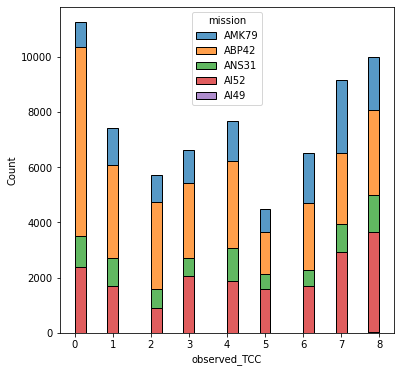

In [ ]:
plt.figure(figsize = (6, 6))
sns.histplot(data, x = 'observed_TCC', hue = 'mission', multiple = 'stack')

In [ ]:
data = shuffle(data).reset_index(drop = True)

In [ ]:
#train-test random split
test_data = data.loc[61000:68750,:].reset_index(drop=True)
train_data = data.loc[:60999,:].reset_index(drop=True)

In [ ]:
train_model(model, 
            train_data,
            test_data,
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.00005,
            lr_scheduler_params = {'patience':2, 'threshold':0.0001},
            s_eq = iaa.Sequential([
                                  iaa.Fliplr(0.5), # horizontally flip 50% of the images
                                   iaa.GaussianBlur(sigma=(0, 3.0)),
                                   iaa.Flipud(0.5),
                                   iaa.Affine(rotate = (-30,30),scale=(0.5, 1.5))                                                    
                                  ]), 
            batch_size= 256)


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 239/239 [24:13<00:00,  6.08s/it]


Validating epoch

Validation metrics: 
{'loss': 0.006056332029402256, 'accuracy': 46.83266675267707}
Best model yet, saving
Epoch 1


100%|██████████| 239/239 [17:19<00:00,  4.35s/it]


Validating epoch

Validation metrics: 
{'loss': 0.005811895243823528, 'accuracy': 47.593858856921685}
Best model yet, saving


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 2


100%|██████████| 239/239 [17:18<00:00,  4.35s/it]


Validating epoch

Validation metrics: 
{'loss': 0.00539693096652627, 'accuracy': 50.677331957166814}
Best model yet, saving


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 3


100%|██████████| 239/239 [17:12<00:00,  4.32s/it]


Validating epoch

Validation metrics: 
{'loss': 0.005149856675416231, 'accuracy': 53.21893949167849}
Best model yet, saving


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 4


100%|██████████| 239/239 [17:14<00:00,  4.33s/it]


Validating epoch

Validation metrics: 
{'loss': 0.005350863095372915, 'accuracy': 51.38691781705587}


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 5


100%|██████████| 239/239 [17:19<00:00,  4.35s/it]


Validating epoch

Validation metrics: 
{'loss': 0.005891351029276848, 'accuracy': 49.23235711521094}


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 6


100%|██████████| 239/239 [17:20<00:00,  4.35s/it]


Validating epoch

Validation metrics: 
{'loss': 0.006031247787177563, 'accuracy': 48.05831505612179}


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 7


100%|██████████| 239/239 [17:48<00:00,  4.47s/it]


Validating epoch

Validation metrics: 
{'loss': 0.0055833375081419945, 'accuracy': 51.56753967230035}


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 8


100%|██████████| 239/239 [18:18<00:00,  4.60s/it]


Validating epoch

Validation metrics: 
{'loss': 0.005598753225058317, 'accuracy': 51.864275577344856}


  0%|          | 0/239 [00:00<?, ?it/s]

Epoch 9


 62%|██████▏   | 148/239 [11:23<06:56,  4.58s/it]

In [ ]:
the_model = torch.load('/content/drive/MyDrive/geo_kaggle/best_alex_full.pth')


In [ ]:
print(the_model)

In [ ]:
with open('/content/drive/MyDrive/geo_kaggle_test/index.pkl', 'rb') as f:
    data_index = pickle.load(f)
data_valid = pd.DataFrame(data_index)

In [ ]:
target = GetTarget(data_valid,the_model)

100%|██████████| 270/270 [06:21<00:00,  1.41s/it]


In [ ]:
target

,jpg_filename,TCC
0,404863be-8c7b-4aba-9a11-70e61099068e.jpg,8
1,1db7c21a-a0e7-48b1-8f9d-ab2e5124064d.jpg,8
2,c1fd8fc6-d0a3-404b-b533-ea62b9a1b559.jpg,8
3,70b7bf82-e6b6-48cd-8ce1-51cc4db4b914.jpg,8
4,2a271026-72db-4fa6-9457-51ee47a51340.jpg,8
...,...,...
26993,33b15d31-f370-4be3-9f96-eb70818c7b9d.jpg,8
26994,18f65dbc-d80e-4177-8998-7eb026ad69a8.jpg,1
26995,04cb832a-d8e5-4138-957f-5e011f7a3def.jpg,8
26996,cd7bcaaf-f29b-41af-817b-c16ddef21fdc.jpg,8


In [ ]:
target.to_csv('/content/alex_full_try.csv', sep=',' , index=False)

Due to parallel loading of data some objects are not evaluated (usually less than 1 per cent)
Here are their names

In [ ]:
(pd.concat([target['jpg_filename'], data_valid['jpg_filename']])).drop_duplicates(keep=False)

26997    1b4a02b2-1706-4f40-b9a1-437e49a857e7.jpg
26999    0824f176-2f23-4e16-9fdf-6a411da2979a.jpg
Name: jpg_filename, dtype: object